# **Consumer Analytical Profile Analysis 1 Month Interactions (QA)**

In [1]:
%run bi_feature_eng_utilities.ipynb 
!pip install pyarrow
!pip install dask
#Clean up previous tables
!aws s3 rm --recursive s3://datascience-workspace-dev/buyer-intent/user_interactions/tables

    100% |████████████████████████████████| 122kB 33.7MB/s ta 0:00:01
    100% |████████████████████████████████| 133kB 6.0MB/s ta 0:00:01
    100% |████████████████████████████████| 5.8MB 7.9MB/s eta 0:00:01    32% |██████████▎                     | 1.9MB 79.5MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/16/8a/1fc3dba0c4923c2a76e1ff0d52b305c44606da63f718d14d3231e21c51b0/s3transfer-0.2.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/83/94/7179c3832a6d45b266ddb2aac329e101367fbdb11f425f13771d27f225bb/jmespath-0.9.4-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/41/17/c62faccbfbd163c7f57f3844689e3a78bae1f403648a6afb1d0866d87fbb/python_dateutil-2.8.0-py2.py3-none-any.whl
    100% |████████████████████████████████| 133kB 49.4MB/s ta 0:00:01
  Using cached https://files.pythonhosted.org/packages/22/cd/a6aa959dca619918ccb55023b4cb151949c64d4d5d55b3f4ffd7eee0c6e8/docutils-0.15.2-py3-none-any.whl
  Running setu

In [2]:
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pickle
from scipy import stats
from sklearn.cluster import KMeans
from datetime import datetime
import pyarrow.parquet as pq
import dask.dataframe as dd
import s3fs
import multiprocessing
from sklearn.impute import SimpleImputer
import seaborn as sns
from matplotlib import pyplot

s3 = s3fs.S3FileSystem()

In [3]:
# It runs k-mean for up to up_to_max_cluster_number ()
def run_k_mean(df, up_to_max_cluster_number, title):
    distortions = []
    for i in range(1, up_to_max_cluster_number):
        print('iteration {}'.format(i))
        km = KMeans(
            n_clusters=i, 
            init='random',
            n_init=10, 
            max_iter=300,
            tol=1e-04, 
            random_state=0,
            n_jobs=multiprocessing.cpu_count()-2 
        )
        km.fit(df)
        distortions.append(km.inertia_)

    df_labels = km.predict(df)
    df_centroids = km.cluster_centers_

    # plot number of clusters against distoration to find optimal number of clusters for 
    plt.plot(range(1, up_to_max_cluster_number), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.title(title)
    plt.show()

    return (df_labels, df_centroids, distortions )

In [4]:
user_interactions_db_handler= FeatureEngineeringUtilities(db_name= 'buyer_intent_user_interactions', 
                                                          db_path_on_s3 = 's3://datascience-workspace-dev/buyer-intent/user_interactions', 
                                                          logger_name = 'buyer_intent')

2019-12-09 18:21:40.352 INFO athena_util.py.111 - Read config from default schema
2019-12-09 18:21:40.353 INFO athena_util.py.114 - Schema fetched from default config file:


In [5]:
from datetime import datetime, timedelta
k = 60
k_days_ago= datetime.now() - timedelta(days= k)
k_days_ago_str = str(k_days_ago)[:10]
k_days_ago_str = k_days_ago_str.replace('-','')

ctas_sql_time_filter = """CREATE TABLE buyer_intent_user_interactions.biui_qa_consumer_analytical_profile_summary_t030_{}
WITH (
external_location = 's3://datascience-workspace-dev/buyer-intent/user_interactions/tables/biui_qa_consumer_analytical_profile_summary_t030_{}',
format='PARQUET'
) AS
SELECT * FROM buyer_intent_user_interactions.biui_qa_consumer_analytical_profile_summary_t030
WHERE  snapshot_date_mst_yyyymmdd = '{}';""".format(k_days_ago_str, k_days_ago_str, k_days_ago_str)

In [6]:
user_interactions_db_handler.drop_table('biui_qa_consumer_analytical_profile_summary_t030_{}'.format(k_days_ago_str))
user_interactions_db_handler.run_ctas_query(ctas_sql_time_filter)

2019-12-09 18:21:43.433 INFO athena_util.py.441 - s3://datascience-workspace-dev/buyer-intent/user_interactions
2019-12-09 18:21:43.623 INFO athena_util.py.462 - 2019-12-09 18:21:43.623950
2019-12-09 18:21:45.691 INFO athena_util.py.464 - 2019-12-09 18:21:45.691627
2019-12-09 18:21:45.797 INFO athena_util.py.441 - s3://datascience-workspace-dev/buyer-intent/user_interactions
2019-12-09 18:21:45.865 INFO athena_util.py.462 - 2019-12-09 18:21:45.865640
2019-12-09 18:21:49.479 INFO athena_util.py.464 - 2019-12-09 18:21:49.479135


In [7]:
res = user_interactions_db_handler.get_table_size('biui_qa_consumer_analytical_profile_summary_t030_{}'.format(k_days_ago_str))
print(res)

2019-12-09 18:21:49.535 INFO athena_util.py.441 - s3://datascience-workspace-dev/buyer-intent/user_interactions
2019-12-09 18:21:49.597 INFO athena_util.py.462 - 2019-12-09 18:21:49.597916
2019-12-09 18:21:51.140 INFO athena_util.py.464 - 2019-12-09 18:21:51.140256
0


In [11]:
s3_data_path = 's3://datascience-workspace-dev/buyer-intent/user_interactions/tables/{}'.format('biui_qa_consumer_analytical_profile_summary_t030_{}'.format(k_days_ago_str))
print(s3_data_path)

s3://datascience-workspace-dev/buyer-intent/user_interactions/tables/biui_qa_consumer_analytical_profile_summary_t030_20191010


In [12]:
df = pq.ParquetDataset(s3_data_path, filesystem=s3).read_pandas().to_pandas()
df.head(5)

OSError: Passed non-file path: s3://datascience-workspace-dev/buyer-intent/user_interactions/tables/biui_qa_consumer_analytical_profile_summary_t030_20191010

## **Basic Statistical Analysis**

In [10]:
unique_users = len(df['member_id'].unique())
print("number of unique users : {}".format(unique_users))

NameError: name 'df' is not defined

In [148]:
unique_segments = df['ldp_dominant_segment'].unique()
print("class of diffrent segment : {}".format(unique_segments))

class of diffrent segment : ['no_segment' 'for sale' 'not for sale' 'for rent']


In [149]:
#consider diffrent segments fo analysis
no_segment = df.loc[df['ldp_dominant_segment'] == 'no_segment']
for_sale = df.loc[df['ldp_dominant_segment'] == 'for sale']
not_for_sale = df.loc[df['ldp_dominant_segment'] == 'not for sale'] 
for_rent = df.loc[df['ldp_dominant_segment'] == 'for rent'] 

In [150]:
#Get the size of each segments
print("no segment size is : {}".format(no_segment.shape[0]))
print("for sale segment size is : {}".format(for_sale.shape[0]))
print("nor for sale segment size is : {}".format(not_for_sale.shape[0]))
print("for rent segment size is : {}".format(for_rent.shape[0]))

no segment size is : 72569
for sale segment size is : 53516
nor for sale segment size is : 59372
for rent segment size is : 381


In [151]:
#remove member_id and timestamps at this phase
no_segment = no_segment.drop(columns=["most_recent_ldp_visit_date", "first_ldp_visit_date","most_recent_srp_visit_date","first_srp_visit_date","most_recent_lead_submitted"])
for_sale = for_sale.drop(columns=["most_recent_ldp_visit_date", "first_ldp_visit_date","most_recent_srp_visit_date","first_srp_visit_date","most_recent_lead_submitted"])
not_for_sale = not_for_sale.drop(columns=["most_recent_ldp_visit_date", "first_ldp_visit_date","most_recent_srp_visit_date","first_srp_visit_date","most_recent_lead_submitted"])
for_rent = for_rent.drop(columns=["most_recent_ldp_visit_date", "first_ldp_visit_date","most_recent_srp_visit_date","first_srp_visit_date","most_recent_lead_submitted"])

In [152]:
#Make a distinction between numeric and categorical variables
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

In [153]:
no_segment_numerics = no_segment.select_dtypes(include=numerics)
for_sale_numerics = for_sale.select_dtypes(include=numerics)
not_for_sale_numerics = not_for_sale.select_dtypes(include=numerics) 
for_rent_numerics = for_rent.select_dtypes(include=numerics)

In [154]:
#Basic cleanup operation : remove columns if all elements are missiong
no_segment_numerics = no_segment_numerics.dropna(axis='columns',how='all')
for_sale_numerics = for_sale_numerics.dropna(axis='columns', how='all')
not_for_sale_numerics = not_for_sale_numerics.dropna(axis='columns', how='all')
for_rent_numerics = for_rent_numerics.dropna(axis='columns', how='all')

In [155]:
no_segment_numerics.head(5)

total_saved_listings  total_ldp_page_views  median_ldp_page_views  \
0                     22                   105                      1   
6                     17                    55                      1   
9                     84                   486                      1   
12                    20                   107                      1   
17                    88                   295                      1   

    average_ldp_page_views  average_ldp_dwell_time_seconds  \
0                 1.019417                       88.631068   
6                 1.486486                       78.945946   
9                 1.959677                      115.185484   
12                1.465753                       98.109589   
17                1.347032                       57.771689   

    total_ldp_dwell_time_seconds  median_ldp_dwell_time_seconds  \
0                           9129                             45   
6                           2921                             17   
9                          28566                             53   
12                          7162                             41   
17                         12652                             25   

    minimum_ldp_dwell_time_seconds  maximum_ldp_dwell_time_seconds  \
0                                1                            1539   
6                                1                             807   
9                                5                            1546   
12                               2                            1142   
17                               1                            1738   

    total_distinct_listings_viewed  ...  submitted_leads_basic  \
0                               90  ...                    NaN   
6                               25  ...                    NaN   
9                              179  ...                    NaN   
12                              63  ...                    NaN   
17                             149  ...                    NaN   

    submitted_leads_connection_for_buyers  submitted_leads_for_rent  \
0                                     NaN                       NaN   
6                                     NaN                       NaN   
9                                     NaN                       NaN   
12                                    NaN                       NaN   
17                                    NaN                       NaN   

    submitted_leads_for_sale  submitted_leads_not_for_sale  \
0                        NaN                           NaN   
6                        NaN                           NaN   
9                        NaN                           NaN   
12                       NaN                           NaN   
17                       NaN                           NaN   

    total_lead_dwell_time_seconds  average_lead_dwell_time_seconds  \
0                             NaN                              NaN   
6                             NaN                              NaN   
9                             NaN                              NaN   
12                            NaN                              NaN   
17                            NaN                              NaN   

    median_lead_dwell_time_seconds  minimum_lead_dwell_time_seconds  \
0                              NaN                              NaN   
6                              NaN                              NaN   
9                              NaN                              NaN   
12                             NaN                              NaN   
17                             NaN                              NaN   

    maximum_lead_dwell_time_seconds  
0                               NaN  
6                               NaN  
9                               NaN  
12                              NaN  
17                              NaN  

[5 rows x 56 columns]

In [156]:
#imputing with median for missing values
imp = SimpleImputer(missing_values=np.nan, strategy='median')
imp.fit(no_segment_numerics)
no_segment_numerics = pd.DataFrame(data=imp.transform(no_segment_numerics), 
                                                columns=no_segment_numerics.columns, 
                                                index=no_segment_numerics.index)    

In [157]:
no_segment_numerics.head(5)

total_saved_listings  total_ldp_page_views  median_ldp_page_views  \
0                   22.0                 105.0                    1.0   
6                   17.0                  55.0                    1.0   
9                   84.0                 486.0                    1.0   
12                  20.0                 107.0                    1.0   
17                  88.0                 295.0                    1.0   

    average_ldp_page_views  average_ldp_dwell_time_seconds  \
0                 1.019417                       88.631068   
6                 1.486486                       78.945946   
9                 1.959677                      115.185484   
12                1.465753                       98.109589   
17                1.347032                       57.771689   

    total_ldp_dwell_time_seconds  median_ldp_dwell_time_seconds  \
0                         9129.0                           45.0   
6                         2921.0                           17.0   
9                        28566.0                           53.0   
12                        7162.0                           41.0   
17                       12652.0                           25.0   

    minimum_ldp_dwell_time_seconds  maximum_ldp_dwell_time_seconds  \
0                              1.0                          1539.0   
6                              1.0                           807.0   
9                              5.0                          1546.0   
12                             2.0                          1142.0   
17                             1.0                          1738.0   

    total_distinct_listings_viewed  ...  submitted_leads_basic  \
0                             90.0  ...                    1.0   
6                             25.0  ...                    1.0   
9                            179.0  ...                    1.0   
12                            63.0  ...                    1.0   
17                           149.0  ...                    1.0   

    submitted_leads_connection_for_buyers  submitted_leads_for_rent  \
0                                     1.0                       1.0   
6                                     1.0                       1.0   
9                                     1.0                       1.0   
12                                    1.0                       1.0   
17                                    1.0                       1.0   

    submitted_leads_for_sale  submitted_leads_not_for_sale  \
0                        1.0                           1.0   
6                        1.0                           1.0   
9                        1.0                           1.0   
12                       1.0                           1.0   
17                       1.0                           1.0   

    total_lead_dwell_time_seconds  average_lead_dwell_time_seconds  \
0                             3.0                              2.0   
6                             3.0                              2.0   
9                             3.0                              2.0   
12                            3.0                              2.0   
17                            3.0                              2.0   

    median_lead_dwell_time_seconds  minimum_lead_dwell_time_seconds  \
0                              2.0                              1.0   
6                              2.0                              1.0   
9                              2.0                              1.0   
12                             2.0                              1.0   
17                             2.0                              1.0   

    maximum_lead_dwell_time_seconds  
0                               3.0  
6                               3.0  
9                               3.0  
12                              3.0  
17                              3.0  

[5 rows x 56 columns]

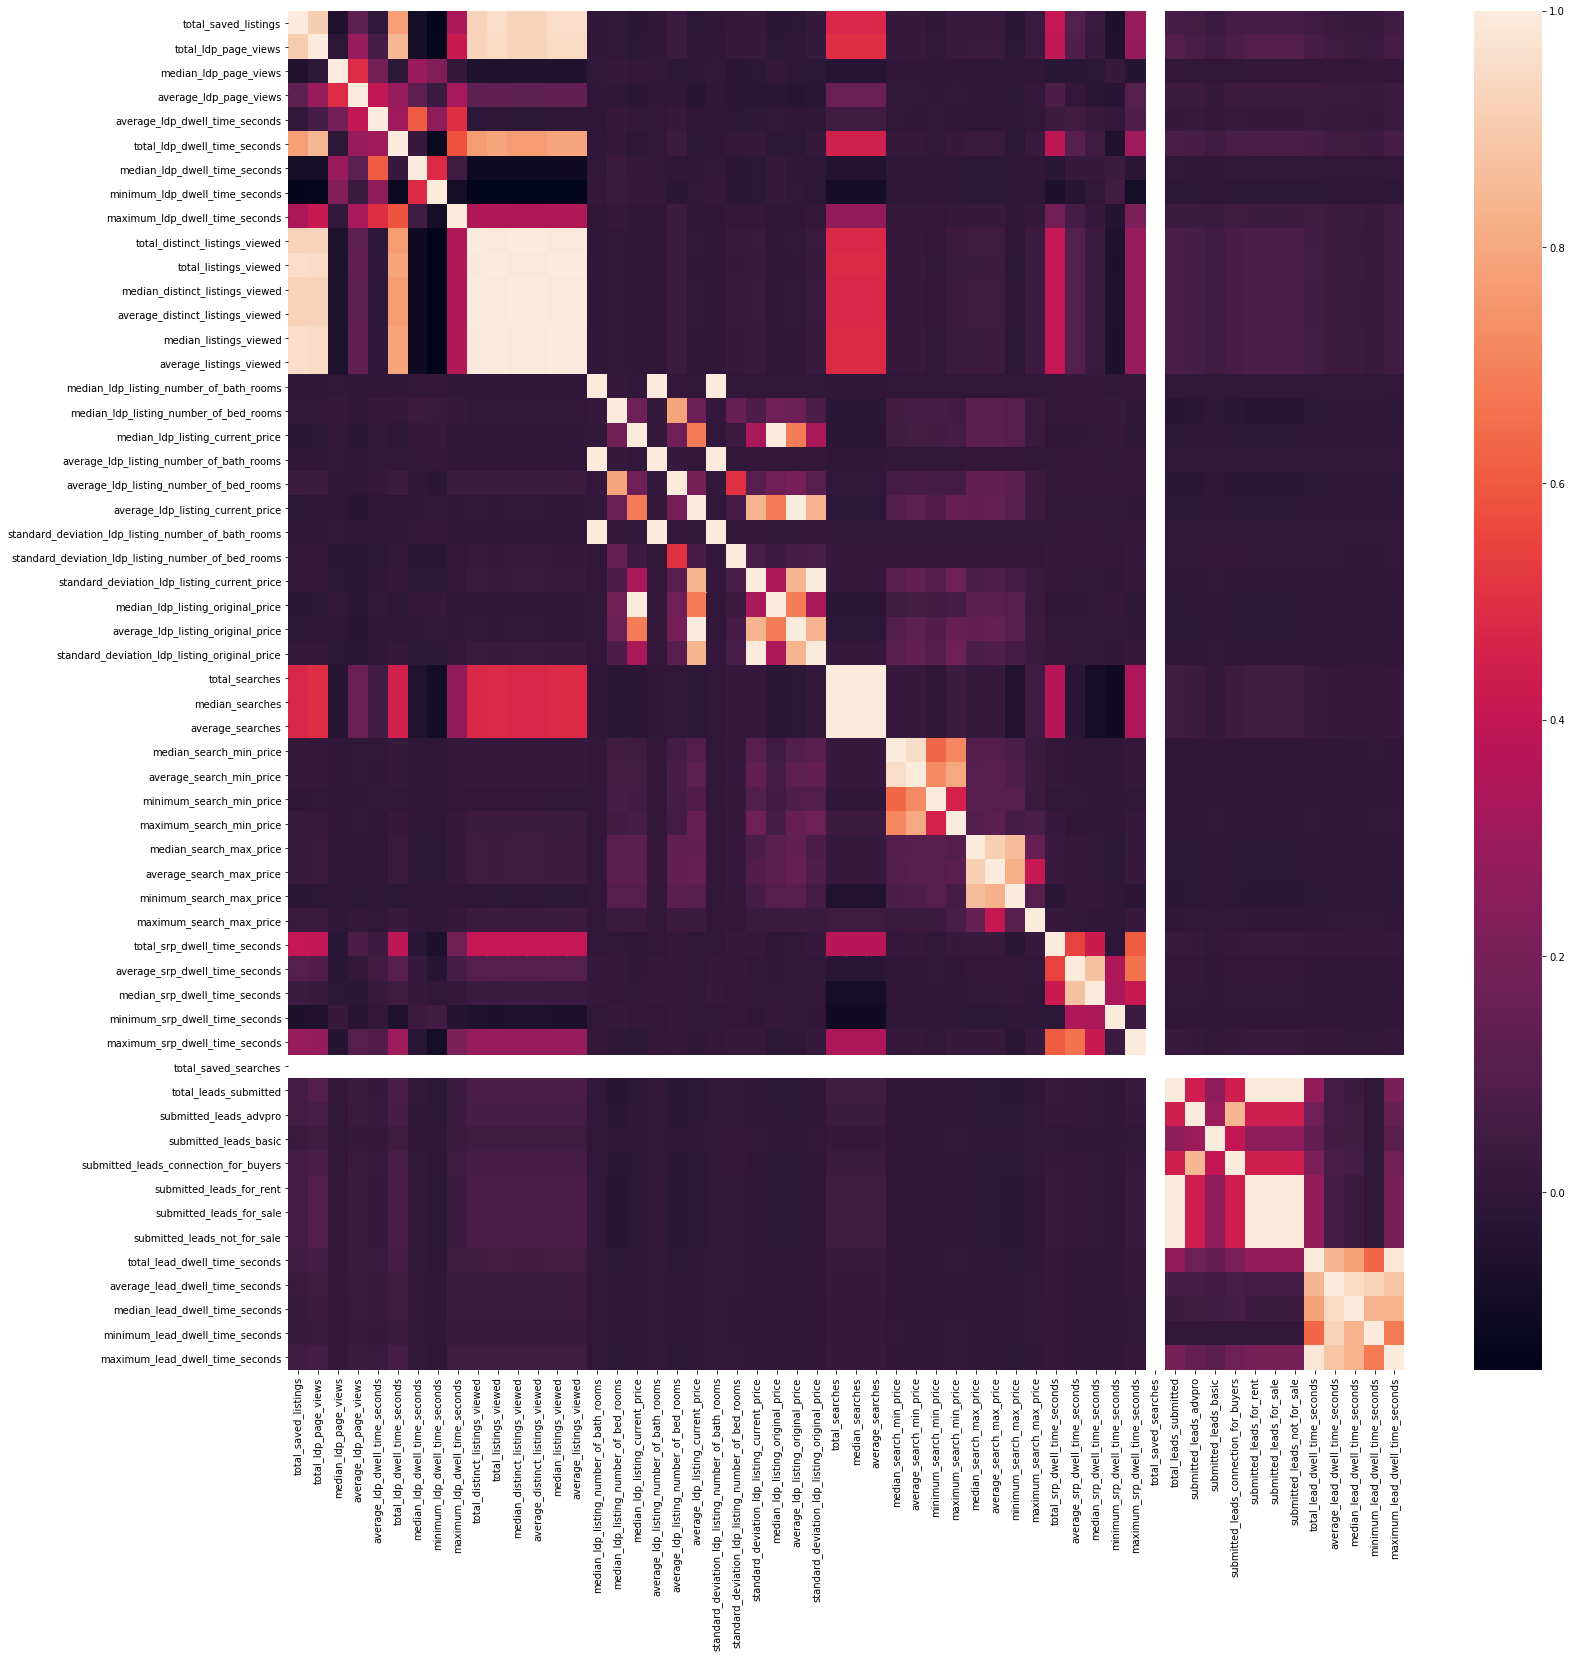

In [158]:
corr_no_segment_numerics = no_segment_numerics.corr()
pyplot.figure(figsize=(25, 25))
sns.heatmap(corr_no_segment_numerics, xticklabels=corr_no_segment_numerics.columns, yticklabels=corr_no_segment_numerics.columns)

### Now Partition Based on different Segments like : ['for sale' 'not for sale' 'no_segment' 'for rent']

In [159]:
df_for_sale = df.loc[df['ldp_dominant_segment'] == 'for sale']
df_no_segment = df.loc[df['ldp_dominant_segment'] == 'no_segment']
df_not_for_sale = df.loc[df['ldp_dominant_segment'] == 'not for sale']
df_for_rent = df.loc[df['ldp_dominant_segment'] == 'for rent']

In [160]:
#Get correlation matrix for possible dimension reduction
corr_df_for_sale = df_for_sale.corr()
corr_df_for_sale.style.background_gradient(cmap='coolwarm')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


In [161]:
corr_df_no_segment = df_no_segment.corr()
corr_df_no_segment.style.background_gradient(cmap='coolwarm')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


In [162]:
corr_df_not_for_sale = df_not_for_sale.corr()
corr_df_not_for_sale.style.background_gradient(cmap='coolwarm')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


In [163]:
corr_df_for_rent = df_for_rent.corr()
corr_df_for_rent.style.background_gradient(cmap='coolwarm')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
